# Russia-Ukraine Conflict Analysis

The following notebook works as a work of research for the analysis of data from the Ethereum network during the period of the Russian-Ukraine conflict.


## Import Statements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from enum import Enum
import math
import seaborn as sns

In [2]:
sns.set_theme()

The first thing to do is create two classes to manage the analysis of degree for the Ethereum datasets in 2021 and compare it with the Russia invasion period (feb. 2022). First, we will create a class to manage the loading and preprocessing of the data.

Five datasets are required to use this class:

- Four "lookup" datasets. They contain 3-month historical data of the degree of all active accounts in each period. The first one has data from January to March, the second one has data from April to June and so forth.
- A single "lookup" dataset corresponding to the period of interest: The one with info from the beginning of the conflict, ranging from 2022 February 10th to 2022 March 10th.

These datasets need to be in the following format:

- They need to be in the same directory.
- They need to have the same name, differing only by a suffix (e.g. "lookup_1, lookup_2, lookup_3, lookup_4 and lookup_war"). These suffixes are hardcoded for now.

After giving information of the filenames and filepaths to that class, you can get a dataframe object back. With that object, we can use another class to use that dataframe object to make all the required analyses.

In [ ]:
class DegreeType(Enum):
    IN_DEGREE = 1
    OUT_DEGREE = 2
    DEGREE = 3
    
class ETHDataProcessor:
    '''
    Collects all the lookup datasets and preprocess all of them to be used in the ETHDegreeAnalyzer class.

    ----------

    #### Attributes:
    
    - datasets_name: str

            Name used for the filenames of the lookup datasets. Defaults to "lookup".

    - lookup_path: str
    
            Path for the lookup dataset files that will be used for the comparasions. Defaults to the current working directory.

    - degree_type: DegreeType

            Type of degree analysis to be performed. Acceps DegreeType.IN_DEGREE, DegreeType.OUT_DEGREE and DegreeType.DEGREE. 
            Defaults to DegreeType.DEGREE.

    ----------

    #### Methods:

    - get_df()

            Loads the dataset in the memory, prepares it and returns it to be used in the ETHDegreeAnalyzer class.
    '''
    def __init__(
                self,
                file_name: str = 'lookup', 
                file_path: str = './',
                degree_type: DegreeType = DegreeType.DEGREE
        ):
        self.file_name = file_name
        self.file_path = file_path
        self.degree_type = degree_type
        self._2021_col_identifier = 'avgValue'
    
    def _concat_lookup(
            self,
            df: pd.DataFrame,
            df_id: str,
            suffix: str
        ) -> pd.DataFrame:
        '''Concatenates a new dataframe with averaged columns on an old dataframe. Returns the merged dataframe.'''
        try:  
            df_name = self.lookup_path+self.datasets_name+'_'+df_id+suffix+'.csv'
            new_df = pd.read_csv(df_name, index_col = 0)
            new_df = pd.DataFrame(new_df.mean(axis = 1), columns = [self._2021_col_identifier+df_id])
        except Exception as e:
            print(f'Warning: {df_name} could not be read": {e}')
            return df
        return df.merge(new_df, how='left', left_index=True, right_index=True).fillna(0)

    def _load_dataset(self) -> pd.DataFrame:
        '''
        Loads into memory all the datasets from the filepath specified concatenated. If any is missing, it will be ignored and
        the function will try to concatenate the others. 
        '''
        match(self.degree_type):
            case DegreeType.IN_DEGREE:
                suffix = '_in'
            case DegreeType.OUT_DEGREE:
                suffix = '_out'
            case DegreeType.DEGREE:
                suffix = ''
            case _:
                raise ValueError('Degree type not recognized.')

        return (
            pd.read_csv(self.lookup_path+self.datasets_name+'_war'+suffix+'.csv', index_col = 0)
            .pipe(self._concat_lookup, df_id = '1', suffix = suffix)
            .pipe(self._concat_lookup, df_id = '2', suffix = suffix)
            .pipe(self._concat_lookup, df_id = '3', suffix = suffix)
            .pipe(self._concat_lookup, df_id = '4', suffix = suffix)
        )
    
    def _prepare_dataset(self, df: pd.DataFrame) -> None:
        '''Takes a dataframe obejct and transforms it into a DataFrame ready to be used in the Analyzer class.'''
        cols_2021 = []
        for column in df.columns:
            if column.startswith(self._2021_col_identifier):
                cols_2021.append(column)
                df[column] = df[column]/df['degree'] #absolute average value is converted to relative average value
        df['totalVal'] = df[cols_2021].sum(axis = 1)
        df['stdVal'] = df[cols_2021].std(axis = 1)

    def get_df(self) -> pd.DataFrame:
        '''Loads the datasets in memory, preprocesses them to be used in the Analyzer class and returns the dataframe object.'''
        df = self._load_dataset()
        self._prepare_dataset(df)        
        return df

In [3]:
class ETHDegreeAnalyzer:
    '''
    Class responsible for handling degree comparasions in Ethereum for different time periods.

    ----------

    #### Attributes:
    
    - df: DataFrame
        
        DataFrame object to be analyzed.

    ----------

    #### Methods:

    - get_descending_accounts(max_std, min_total_val, min_degree = -1)

            Creates and returns a DataFrame object containing all the accounts that had a sum of relative degree **higher** than a given threshold in 2021.
            Those accounts are expected to have a high number of transactions in 2021 compared to the war period.

    - get_ascending_accounts(max_std, max_total_val, min_degree = -1)

            Creates and returns a DataFrame object containing all the accounts that had a sum of relative degree **lower** than a given threshold in 2021.
            Those accounts are expected to have a low number of transactions in 2021 compared to the the war period.

            

    '''
    def __init__(self, df: pd.DataFrame):
        self._df = df


    def get_descending_accounts(self, max_std: float, min_total_val: float, min_degree: float = -1) -> pd.DataFrame:
        '''
        Constructs a dataframe with the accounts that had a high-ish degree in 2021 and decreased in the period of interest.

        ---

        #### Parameters:

        - max_std: float

            The maximum standard deviation allowed for the 2021 period. The lowest the value, the more stable the accounts will
            need to be to be selected.
        - min_total_val: float

            The minimum value for the summation of the relative degrees in 2021. The lowest the value, the lower the differences
            between 2021 and the war are going to be.
        - min_degree (optional): float

            The lowest degree for the resulting dataframe. Can be used to filter out little activity accounts.

        #### Returns: 
        
        DataFrame
        '''

        result = (
            self._df.query('stdVal > 0 and stdVal <= '+str(max_std)) 
            .query('totalVal > '+str(min_total_val)) 
            .sort_values(by = 'degree', ascending = False) 
        )
        return result if min_degree == -1 else result.query('degree >= '+str(min_degree))
    
    def get_ascending_accounts(self, max_std: float, max_total_val: float, min_degree: float = -1) -> pd.DataFrame:
        '''
        Constructs a dataframe with the accounts that had little activity (but existed!) in 2021 and increased a lot
        in the period of interest.

        ---

        #### Parameters:

        - max_std: float

            The maximum standard deviation allowed for the 2021 period. The lowest the value, the more stable the accounts will
            need to be to be selected.
        - max_total_val: float

            The maximum value for the summation of the relative degrees in 2021. The lowest the value, the bigger the differences
            between 2021 and the war are going to be.
        - min_degree (optional): float

            The lowest degree for the resulting dataframe. Can be used to filter out little activity accounts.

        #### Returns: 
        
        DataFrame
        '''


        columns_2021 = [col for col in self._df.columns if col.startswith(self._2021_col_identifier)]
        exists_in_2021 = ' and '.join(f'{column} > 0' for column in columns_2021)
        result = (
            self._df.query(exists_in_2021)
            .query('stdVal > 0 and stdVal < '+str(max_std))
            .query('totalVal <= '+str(max_total_val))
            .sort_values(by = 'degree', ascending = False)
        )   
        return result if min_degree == -1 else result.query('degree >= '+str(min_degree))
    

In [4]:
degree_analyzer = ETHDegreeAnalyzer(lookup_path='../data/')
asc_df = degree_analyzer.get_ascending_accounts(10, 1)
asc_df

,degree,avgValue1,avgValue2,avgValue3,totalVal,stdVal
0xfbddadd80fe7bda00b901fbaf73803f2238ae655,248829.0,0.078596,0.142731,0.297560,0.518887,0.112569
0x283af0b28c62c092c9727f1ee09c02ca627eb7f5,152168.0,0.136691,0.300589,0.515829,0.953109,0.190147
0x15d4c048f83bd7e37d49ea4c83a07267ec4203da,111325.0,0.097795,0.084388,0.268233,0.450415,0.102492
0x58b6a8a3302369daec383334672404ee733ab239,100918.0,0.109653,0.163395,0.062899,0.335948,0.050288
0xb0cf943cf94e7b6a2657d15af41c5e06c2bfea3d,87807.0,0.101507,0.115765,0.149050,0.366322,0.024398
...,...,...,...,...,...,...
0xe6d23a63e5a5c6f3f7bf4351cfdb1923a4c1045e,2.0,0.166667,0.250000,0.333333,0.750000,0.083333
0x096aa77a9f0a0408be6a405578108df31d15452f,2.0,0.166667,0.250000,0.333333,0.750000,0.083333
0x11ec84106d1b4503ce16ff95ee436487497dc9ae,2.0,0.166667,0.250000,0.500000,0.916667,0.173472
0x468452b52eb84eee68a78dbd38db191a436aece4,2.0,0.166667,0.500000,0.333333,1.000000,0.166667


In [5]:
def plot_ascending_account(
        df: pd.DataFrame,
        hash: str,
        ax: plt.Axes,
        lookup_in: pd.DataFrame = None,
        lookup_out: pd.DataFrame = None,
    ) -> None:
    sns.set_theme()
    long_asc = df.copy()
    long_asc['avgValue1'] = long_asc['avgValue1']*long_asc['degree']
    long_asc['avgValue2'] = long_asc['avgValue2']*long_asc['degree']
    long_asc['avgValue3'] = long_asc['avgValue3']*long_asc['degree']
    long_asc.rename(inplace = True, 
                    columns = {'avgValue1': '01/21 to 03/21', 'avgValue2': '04/21 to 06/21',
                                'avgValue3': '07/21 to 09/21', 'degree': 'Russian Invasion'}
    )
    long_asc = pd.melt(long_asc, ignore_index = False, value_vars= ['01/21 to 03/21', '04/21 to 06/21', 
                                                                    '07/21 to 09/21', 'Russian Invasion'],
                       value_name='Degree', var_name = ['Time Period']
    )
    sns.lineplot(data = long_asc.loc[hash].sort_values(by = ['Time Period']), x = 'Time Period', y = 'Degree', ax = ax)
    sns.scatterplot(data = long_asc.loc[hash].sort_values(by = ['Time Period']), x = 'Time Period', y = 'Degree', ax = ax)

    if lookup_in is not None:
        lookup_in['avgValue1'] = lookup_in['avgValue1']*lookup_in['degree']
        lookup_in['avgValue2'] = lookup_in['avgValue2']*lookup_in['degree']
        lookup_in['avgValue3'] = lookup_in['avgValue3']*lookup_in['degree']
        lookup_in.rename(inplace = True, 
                        columns = {'avgValue1': '01/21 to 03/21', 'avgValue2': '04/21 to 06/21',
                                    'avgValue3': '07/21 to 09/21', 'degree': 'Russian Invasion'}
        )
        lookup_in = pd.melt(lookup_in, ignore_index = False, value_vars= ['01/21 to 03/21', '04/21 to 06/21', 
                                                                        '07/21 to 09/21', 'Russian Invasion'],
                        value_name='Degree', var_name = ['Time Period']
        )

        sns.lineplot(data = lookup_in.loc[hash].sort_values(by = ['Time Period']), x = 'Time Period', y = 'Degree', ax = ax.twinx())
        sns.scatterplot(data = lookup_in.loc[hash].sort_values(by = ['Time Period']), x = 'Time Period', y = 'Degree', ax = ax.twinx())
    ax.set_title(hash)

In [15]:
def separate_degree_in_months(df: pd.DataFrame, hash: str) -> pd.DataFrame:
    long_asc = df.copy()
    long_asc['avgValue1'] = long_asc['avgValue1'] * long_asc['degree']
    long_asc['avgValue2'] = long_asc['avgValue2'] * long_asc['degree']
    long_asc['avgValue3'] = long_asc['avgValue3'] * long_asc['degree']
    long_asc.rename(inplace = True, 
                    columns = {'avgValue1': '01/21 to 03/21', 'avgValue2': '04/21 to 06/21',
                                'avgValue3': '07/21 to 09/21', 'degree': 'Russian Invasion'}
    )
    long_asc = pd.melt(long_asc, ignore_index = False, value_vars= ['01/21 to 03/21', '04/21 to 06/21', 
                                                                    '07/21 to 09/21', 'Russian Invasion'],
                       value_name='Degree', var_name = ['Time Period']
    )
    try: 
        result = long_asc.loc[hash].sort_values(by = ['Time Period'])
    except KeyError:
        print(long_asc)
        return pd.DataFrame(index = [hash],
                            columns = {
                                'Degree': [0,0,0,0], 
                                'Time Period': ['01/21 to 03/21', '04/21 to 06/21', '07/21 to 09/21', 'Russian Invasion']
                            }
        )
    return result        

def plot_ascending_accounts(
        df: pd.DataFrame,
        hash_list: list,
        fig: plt.figure,
        lookup_in: pd.DataFrame,
        lookup_out: pd.DataFrame
    ) -> None:

    n = math.sqrt(len(hash_list))
    if not n.is_integer():
        raise ValueError('You need to use a square number of accounts.')
    n = int(n)
    
    outer = gridspec.GridSpec(n, n, wspace=0.6, hspace=0.6)
    for i in range(len(hash_list)):
        inner = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec = outer[i], wspace = 0.1, hspace = 0.4)
        ax = plt.Subplot(fig, inner[0])
        df_degree = separate_degree_in_months(df, hash_list[i])
        sns.lineplot(data = df_degree, x = 'Time Period', y = 'Degree', ax = ax)
        sns.scatterplot(data = df_degree, x = 'Time Period', y = 'Degree', ax = ax)
        ax.set_title(hash_list[i])
        fig.add_subplot(ax)

        ax_1 = plt.Subplot(fig, inner[1])
        df_in = separate_degree_in_months(lookup_in, hash_list[i])
        sns.lineplot(data = df_in, x = 'Time Period', y = 'Degree', ax = ax_1)
        sns.scatterplot(data = df_in, x = 'Time Period', y = 'Degree', ax = ax_1)
        fig.add_subplot(ax_1)

        ax_2 = plt.Subplot(fig, inner[2])
        df_out = separate_degree_in_months(lookup_out, hash_list[i])
        sns.lineplot(data = df_out, x = 'Time Period', y = 'Degree', ax = ax_2)
        sns.scatterplot(data = df_out, x = 'Time Period', y = 'Degree', ax = ax_2)
        fig.add_subplot(ax_2)

In [7]:
del degree_analyzer
degree_analyzer = ETHDegreeAnalyzer(lookup_path='../data/', degree_type=DegreeType.IN_DEGREE)
lookup_in = degree_analyzer.get_ascending_accounts(10, 1)

In [8]:
del degree_analyzer
degree_analyzer = ETHDegreeAnalyzer(lookup_path='../data/', degree_type=DegreeType.OUT_DEGREE)
lookup_out = degree_analyzer.get_ascending_accounts(10, 1)

                                                 Time Period       Degree
from                                                                     
0xb0cf943cf94e7b6a2657d15af41c5e06c2bfea3d    01/21 to 03/21  8902.333333
0x042523db4f3effc33d2742022b2490258494f8b3    01/21 to 03/21   399.666667
0x60b86af869f23aeb552fb7f3cabd11b829f6ab2f    01/21 to 03/21   382.000000
0xba4cd55471ff7254042d88bc2a3ee740def0a5cd    01/21 to 03/21   505.333333
0x77696bb39917c91a0c3908d577d5e322095425ca    01/21 to 03/21    14.666667
...                                                      ...          ...
0x71bee6e57fbb9f7213cdb0fea07a082f77519c09  Russian Invasion     2.000000
0x7f66b27da2ddcdc1b4c4a2aaf608d7ecb68588d7  Russian Invasion     2.000000
0x71b212e65acf711017368e0c86c8a39bbf47b404  Russian Invasion     2.000000
0x7f65bfef5d242a53243462d5034e6e0cfa1fde65  Russian Invasion     2.000000
0xdf598aa801a19f9f15b5491ee64c80aa5f5bbae2  Russian Invasion     2.000000

[143656 rows x 2 columns]
           

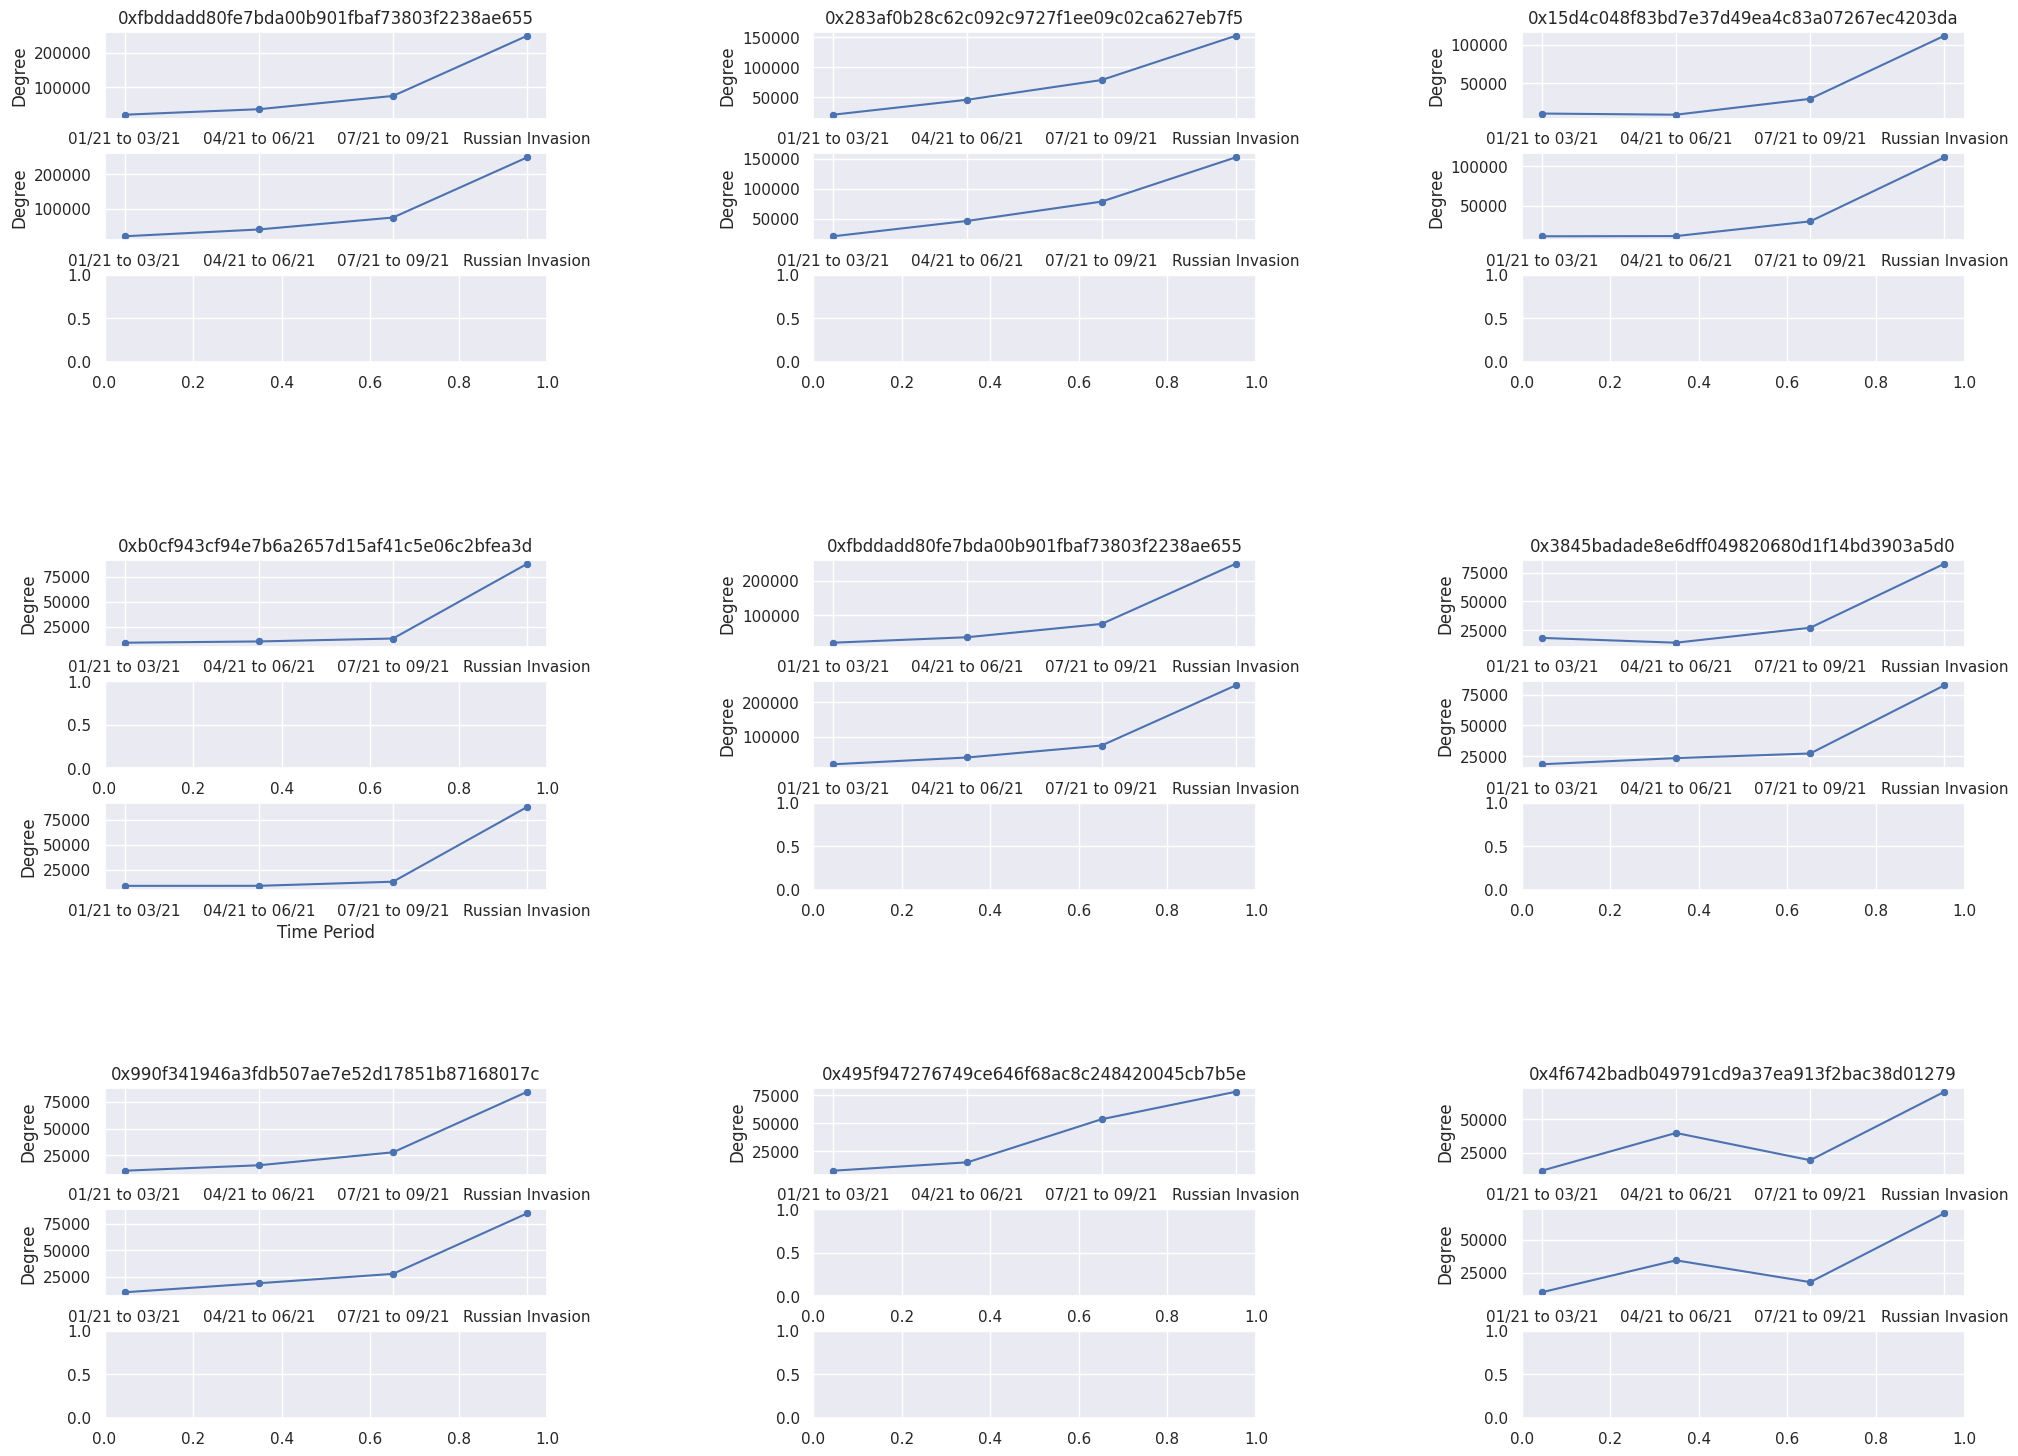

In [16]:
fig = plt.figure(figsize=(24, 18))
#fig, axes = plt.subplots(3, 3, figsize=(24, 18))
hash_list = [
    '0xfbddadd80fe7bda00b901fbaf73803f2238ae655',
    '0x283af0b28c62c092c9727f1ee09c02ca627eb7f5',
    '0x15d4c048f83bd7e37d49ea4c83a07267ec4203da',
    '0xb0cf943cf94e7b6a2657d15af41c5e06c2bfea3d',
    '0xfbddadd80fe7bda00b901fbaf73803f2238ae655',
    '0x3845badade8e6dff049820680d1f14bd3903a5d0',
    '0x990f341946a3fdb507ae7e52d17851b87168017c',
    '0x495f947276749ce646f68ac8c248420045cb7b5e',
    '0x4f6742badb049791cd9a37ea913f2bac38d01279'
             ]
plot_ascending_accounts(asc_df, hash_list, fig, lookup_in, lookup_out)
#plot_ascending_account(asc_df, '0xfbddadd80fe7bda00b901fbaf73803f2238ae655', fig)
#plot_ascending_account(asc_df, '0x283af0b28c62c092c9727f1ee09c02ca627eb7f5', fig)
#plot_ascending_account(asc_df, '0x15d4c048f83bd7e37d49ea4c83a07267ec4203da', fig)
#plot_ascending_account(asc_df, '0x58b6a8a3302369daec383334672404ee733ab239', fig)
#plot_ascending_account(asc_df, '0xb0cf943cf94e7b6a2657d15af41c5e06c2bfea3d', fig)
#plot_ascending_account(asc_df, '0x990f341946a3fdb507ae7e52d17851b87168017c', fig)
#plot_ascending_account(asc_df, '0x3845badade8e6dff049820680d1f14bd3903a5d0', fig)
#plot_ascending_account(asc_df, '0x495f947276749ce646f68ac8c248420045cb7b5e', fig)
#plot_ascending_account(asc_df, '0x4f6742badb049791cd9a37ea913f2bac38d01279', fig)
#fig.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

In [28]:
des_df = degree_analyzer.get_descending_accounts(10, 25)
des_df

,degree,avgValue1,avgValue2,avgValue3,totalVal,stdVal
from,,,,,,
0xa1d8d972560c2f8144af871db508f0b0b10a3fbf,12392,15.191817,11.466457,9.518264,36.176539,2.882793
0x0a98fb70939162725ae66e626fe4b52cff62c2e5,2855,12.611092,8.634910,4.039930,25.285931,4.289302
0x46705dfff24256421a05d056c29e81bdc09723b8,2648,14.317221,7.532603,4.149673,25.999496,5.177745
0xfdb16996831753d5331ff813c29a93c76834a0ad,2409,14.300955,7.610350,3.924588,25.835893,5.260197
0x18916e1a2933cb349145a280473a5de8eb6630cb,1996,24.061790,8.066633,6.216934,38.345357,9.812452
...,...,...,...,...,...,...
0xc9237ef537ea8ea6329ec1393aa83690a09b9e91,1,9.000000,12.333333,7.000000,28.333333,2.694301
0xc924f1c9f1fd11b64dc5a1fb1db2136c07390130,1,12.000000,15.666667,14.000000,41.666667,1.835857
0xc924df9194e93dffbb4bdb386e13062a0217476f,1,4.000000,13.666667,12.666667,30.333333,5.315944


In [30]:
des_df.iloc[:9]

,degree,avgValue1,avgValue2,avgValue3,totalVal,stdVal
from,,,,,,
0xa1d8d972560c2f8144af871db508f0b0b10a3fbf,12392,15.191817,11.466457,9.518264,36.176539,2.882793
0x0a98fb70939162725ae66e626fe4b52cff62c2e5,2855,12.611092,8.634910,4.039930,25.285931,4.289302
0x46705dfff24256421a05d056c29e81bdc09723b8,2648,14.317221,7.532603,4.149673,25.999496,5.177745
0xfdb16996831753d5331ff813c29a93c76834a0ad,2409,14.300955,7.610350,3.924588,25.835893,5.260197
0x18916e1a2933cb349145a280473a5de8eb6630cb,1996,24.061790,8.066633,6.216934,38.345357,9.812452
0xab5c66752a9e8167967685f1450532fb96d5d24f,1979,19.035203,9.999158,5.289372,34.323733,6.985462
0x03cf2fd02edcf3875f7d59328efc87c00f3da244,1882,1.455367,15.945448,11.391959,28.792774,7.409820
0xeee28d484628d41a82d01e21d12e2e78d69920da,1599,21.621222,11.685428,6.452783,39.759433,7.704783
0x0000a0756737268a633cd9296f1b154cf74430b6,1262,6.837559,16.810090,7.670629,31.318278,5.532858


                                                 Time Period   Degree
to                                                                   
0xfbddadd80fe7bda00b901fbaf73803f2238ae655    01/21 to 03/21  19557.0
0x283af0b28c62c092c9727f1ee09c02ca627eb7f5    01/21 to 03/21  20800.0
0x15d4c048f83bd7e37d49ea4c83a07267ec4203da    01/21 to 03/21  10887.0
0x58b6a8a3302369daec383334672404ee733ab239    01/21 to 03/21  11066.0
0xb5d85cbf7cb3ee0d56b3bb207d5fc4b82f43f511    01/21 to 03/21      1.0
...                                                      ...      ...
0xb99d01cb75e3291edb4571a76b11079ad1127c4e  Russian Invasion      2.0
0xb99c46ccd1b0fc286e5b270cfa08175735842f2c  Russian Invasion      2.0
0xb9bbe7477a1991fc9a467d0a21fb84869b36e256  Russian Invasion      2.0
0xb9ba40412394a4ccc1c03c5e0d373ee610e70dba  Russian Invasion      2.0
0x00c4b398500645eb5da00a1a379a88b11683ba01  Russian Invasion      2.0

[68356 rows x 2 columns]
                                                 Time Period    

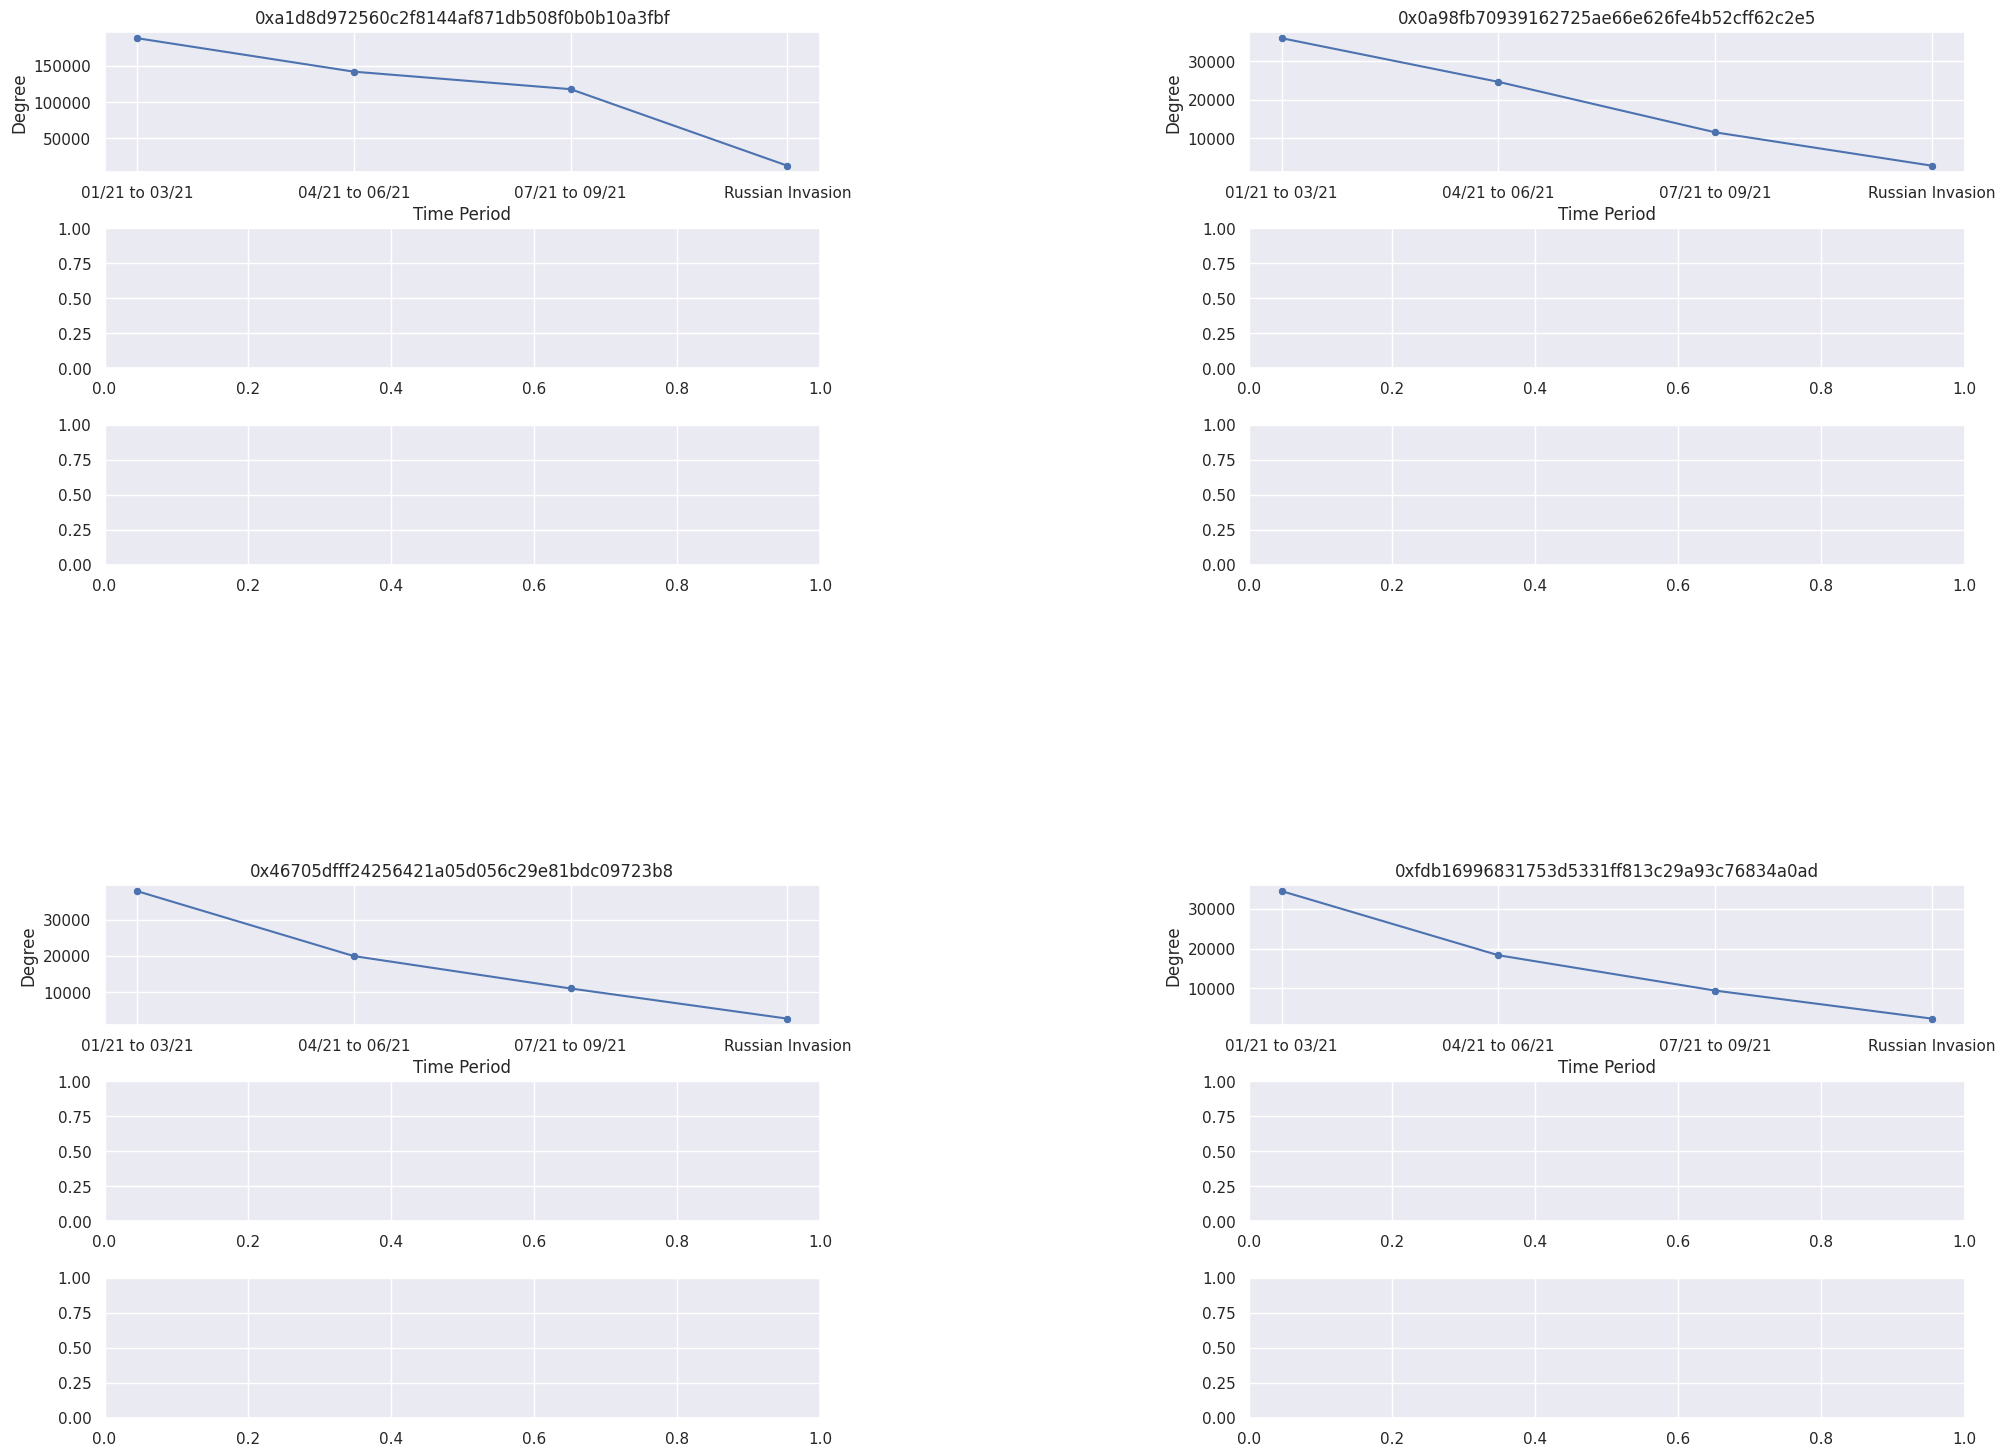

In [29]:
fig = plt.figure(figsize=(24, 18))
hash_list = [
    '0xa1d8d972560c2f8144af871db508f0b0b10a3fbf',
    '0x0a98fb70939162725ae66e626fe4b52cff62c2e5',
    '0x46705dfff24256421a05d056c29e81bdc09723b8',
    '0xfdb16996831753d5331ff813c29a93c76834a0ad'
]
plot_ascending_accounts(des_df, hash_list, fig, lookup_in, lookup_out)